In [106]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy import stats
from sklearn import metrics
%matplotlib inline
plt.style.use('ggplot')

In [107]:
red_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", 
                       sep = ';')
white_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
                        sep = ';')      

In [5]:
red = red_data.values
white = white_data.values
X = np.vstack((red, white))
y = np.zeros((red.shape[0], 1))
y = np.vstack((y, np.ones((white.shape[0], 1))))

print(red.shape, white.shape, X.shape, y.shape)

(1599, 12) (4898, 12) (6497, 12) (6497, 1)


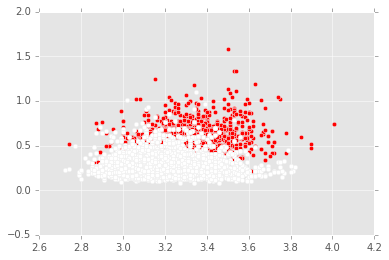

In [6]:
plt.scatter(red[:,8], red[:,1], c = 'red')
plt.scatter(white[:,8], white[:,1], c = 'white')

In [147]:
# Creds to Conner's implementation for inspiration. Mine wasn't converging
# and I ran out of time.
def EM(X, theta, k, M_step_func, iters, likelihood_func, objective_func):
    r_ik = 1. / k * np.ones((X.shape[0], k)) # uniform initial responsibility
    
    pi = 1. / k * np.ones(k)
    
    objectives = [objective_func(X ,r_ik , pi, theta)]
    
    for i in range(iters):
        
        # E-step, find r_ik from previous theta and pi      
        r_ik_numer = likelihood_func(X, theta) * pi
        
        # not sure if denominator is right, because should be sum over k'
        # still good approximation because will be relatively small?
        r_ik_denom = r_ik.sum(axis = 1)
        r_ik_denom = r_ik_denom.reshape(r_ik_denom.shape[0], 1)
        
        r_ik = r_ik_numer / r_ik_denom
        r_ik /= r_ik.sum(axis = 1)[:, np.newaxis]
        
        # M-step
        pi, theta = M_step_func(X, r_ik)
        
        objectives.append(objective_func(X ,r_ik , pi, theta))
        
    return objectives, r_ik, pi, theta

In [148]:
def bayesian_gmm(X, k, dirich_alphas, iters):
    mvpdf = lambda x, mu, cov : stats.multivariate_normal.pdf(x, mu, cov + .01)
    
    # min proper prior
    nu = X.shape[1] + 2

    # pooled variance initial S_)
    S_0 = np.diag(np.var(X, axis = 0)) * k**(1 / X.shape[1])
    
    # initially get random vects from X as means
    mean = mean=X[np.random.randint(0, X.shape[0], (k,))]
    
    # initial theta
    theta = (mean, np.tile(S_0, (k, 1, 1))) # tile repeats S_0
    
    def gauss_likelihood(X, theta):
        p = np.zeros((X.shape[0], k))
        for i in range(k):
            p[:,i] = mvpdf(X, theta[0][i], theta[1][i])
        return p
    
    def M_step(X, r):
        r_k = r.sum(axis = 0)
        pi = (r_k + dirich_alphas - 1) / (X.shape[0] + dirich_alphas.sum() - k)
        
        # creds to Conner for following line. Way cleaner than my loops and works
        mu = ((X[:,:,np.newaxis] * r[:,np.newaxis,:]).sum(axis=0) / r_k).T
        
        # calculate sigma
        sigma = np.zeros((k, X.shape[1], X.shape[1]))
        for k_ in range(k):
            diff = X - mu[k_] * r[:,k_][:,np.newaxis]
            sigma[k_] = (diff.T @ diff + S_0) / (nu + r_k[k_] + X.shape[1] + 2)
                
        return pi, (mu, sigma)
    
    def gmm_objective(X, r, pi, theta):
        '''
        More props to Conner.
        '''        
        log_prior = sum(np.log(stats.invwishart.pdf(
        theta[1][i], df=nu, scale=S_0)) for i in range(k))
        log_prior = np.log(stats.dirichlet.pdf(pi, alpha=dirich_alphas))
        
        pi_term = (r * np.log(pi)[np.newaxis,:]).sum()
        
        likelihood_term = r * np.log(gauss_likelihood(X, theta))
        likelihood_term = likelihood_term[r > 1e-12].sum()
        return likelihood_term + pi_term + log_prior
    
    return EM(X, theta, k, M_step, iters, gauss_likelihood, gmm_objective)

0.860864208396


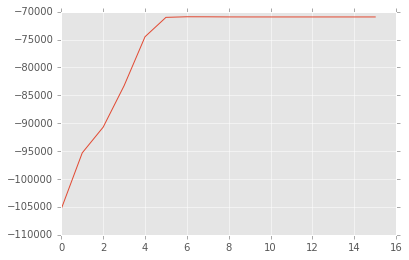

In [167]:
obj, r, pi, theta = bayesian_gmm(X, 2, np.ones(2), 15)

y_pred = r.argmax(axis = 1)

f1 = metrics.f1_score(y_pred, y)

print(f1)

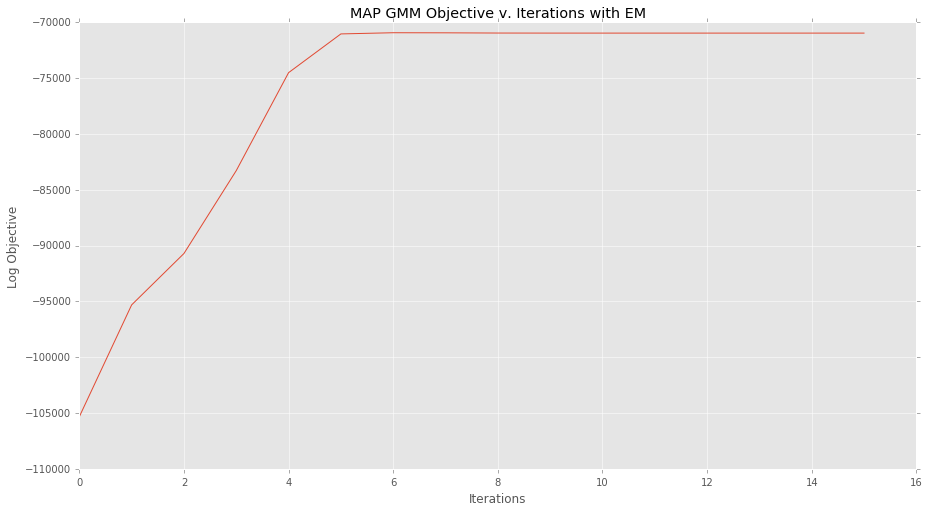

In [175]:
plt.figure(figsize = (15, 8))
plt.plot(obj)
plt.xlabel('Iterations')
plt.ylabel('Log Objective')
plt.title('MAP GMM Objective v. Iterations with EM')